In [112]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Introduction

In this notebook we will investigate Logistic Regression on the Pima Indians Diabetes dataset (https://www.kaggle.com/uciml/pima-indians-diabetes-database) where we will try to predict the onset of Diabetes, based on certain diagnostics and measurements.

Begin by downloading, and importing the data set.

This will be followed by a short recap of logistic regression, and the training procedure. The first set of exercises will ask you to submit a short proof that the sigmoid function always lies between 0 and 1, and also to fit the data-set to a Logistic Regression model.

We then look at choosing the best model for classification. For this, we will consider the same variable selection as seen in the first notebook. We will then have a short introduction on regularization. This is a very important concept in Machine Learning, it can be used to avoid over-fitting, as well as for variable selection (which we will not cover). The second set of exercises consists in choosing the best regularization constant, and exploring its effect on the model.

Finally, we will look at *interpreting* the output of the model to make decisions. We do this by changing the probability thresholds for classification, and explain how we will choose them by considering risk of misclassification.

# Downloading and pre-processing the data

In [113]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We must then split the data into inputs and outputs. We also remove the Insulin variable, since the data is incomplete (there are ways of dealing with incomplete data, but that is not the purpose of this notebook).

In [114]:
outputs = ['Outcome']
inputs = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X = data[inputs]
Y = data[outputs].to_numpy().reshape(-1)

We will now scale the data. Can you explain why this step needs to be done?

_If the inputs are at different scales, the values for each feature are not fairly comparable. For example, a low score in a high scale category could outweigh a high score in a low scale category._

In [115]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Finally, we divide it into a 80 / 20 training and testing split.

In [116]:
num_of_points = len(Y)

idx = list(range(num_of_points))
np.random.shuffle(idx)
idx_train = idx[:int(num_of_points * 0.8)]
idx_train.sort()
idx_test = idx[int(num_of_points * 0.8):]
idx_test.sort()

X_train = X[idx_train, :]
X_test = X[idx_test, :]

Y_train = Y[idx_train]
Y_test = Y[idx_test]

# Logistic Regression

Recall that logistic regression is a model that is very well suited to problems where we have a binary output. That is, we are trying to use certain predictors to classify a particular input into one of two classes. We can write this down more formally.

Assume we have a set of predictors $x \in \mathcal{X}$, and a set of outputs $y \in \{0, 1 \}$. We are then interested in estimating the probability of belonging to a certain class, that is, we want to build an estimator, $\hat{p}(x)$, such that:
$$
\hat{p}(x) = \mathbb{P}( Y = 1 | X = x )
$$

There are many real-world scenarios where this might be the case. Consider for example, we might be interested in predicting if a particular individual infected with COVID will need hospital treatment. In this case, we would define $Y = 1$ the scenario where the individual requires treatment, and $Y = 0$ otherwise. For predictors we could use $X = $ age. 

We could decide to use linear regression, that is, a model of the form:
$$
\hat{p}(x) = \beta_0 + x \beta_1
$$

However, we run into trouble. Probabilities must lie between 0 and 1! The linear model is unable to incorporate this property into its predictions!

We can instead wrap our linear model in a function that guarantees all our outputs lie between 0 and 1. We will be using the sigmoid function, defined as:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

After wrapping the linear model, we obtain the logistic regression model, given by:
$$
\hat{p}(x) = \sigma(\beta_0 + x \beta_1)
$$

Which we can write as:
$$
\hat{p}(x) = \frac{e^{\beta_0 + x \beta_1}}{1 + e^{\beta_0 + x \beta_1}}
$$

# Training the function

The parameters of a linear regression model can be estimated using least squares. However, it is not the best optimiser for logistic regression. This is because we are not estimating $Y$ directly, instead we are estimating $\textit{the probability}$ of Y. This means maximum likelihood estimation is much more appropriate for logistic regression. We can write the likelihood function easily:
$$
\mathcal{L} = \prod_{i : y_i = 1} \mathbb{P}(Y = 1 | X = x_i) \prod_{i' : y_{i'} = 0} (1 - \mathbb{P}(Y = 0 | X = x_{i'}))
$$

Instead of maximising this directly, it is more common to minimise the negative log-likelihood:
$$
\ell(\beta) = - \log \mathcal{L}(\beta) = - \sum_{i : y_i = 1} \log\sigma(x_i^T \beta) - \sum_{i' : y_{i'} = 0}\log \sigma(x_{i'}^T\beta)
$$
So that we choose our parameters, $\hat{\beta}$:
$$
\hat{\beta} = \arg\min_{\beta} \ell(\beta)
$$

Finding the minimum can easily be done using any gradient-based optimiser. In addition, we can also add regularization, which helps us avoid overfitting. We will begin by investigating this.

## Exercise 1:

1. Prove that the sigmoid function always gives an output between 0 and 1. (Hint: consider the limits as $x \rightarrow \pm \infty$, and show the function is always increasing).

2. Using scikit.learn's LogisticRegression class, train a model on the data-set above, make sure you are not regularizing (read the sklearn's documentation! - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Show the model's training and test accuracy, and build a confusion matrix for each set. (Hint: the functions required are $ \texttt{.fit()} $, $\texttt{.predict()}$, and $\texttt{confusion\_matrix()}$.

### Answer 1:
1. As $x \rightarrow \pm \infty$, $x\beta_1 > 0 \Rightarrow \frac{e^{\beta_0 + x \beta_1}}{1 + e^{\beta_0 + x \beta_1}} \rightarrow 1$ and $x\beta_1 < 0 \Rightarrow \frac{e^{\beta_0 + x \beta_1}}{1 + e^{\beta_0 + x \beta_1}} \rightarrow 0$. Thus, we can see for the extremes of x, $\hat{p}(x) \in (0, 1)$. For $x\beta_1 = 0 \Leftarrow \beta_1 = 0$, $\hat{p}(x) = \frac{1}{2}$ always, so for any $x$, the statement stands.

In [117]:
def testModel(y_true, y_pred, verbose=False):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = (cm[0][0] + cm[1][1])/len(y_true)
    if verbose:
        print('  Accuracy:', accuracy)
        print(cm)
    return accuracy
    
logit_model = LogisticRegression(penalty=None)
logit_model.fit(X_train,Y_train)
print('Training data')
testModel(Y_train, logit_model.predict(X_train), True)
print('\nTest data')
testModel(Y_test, logit_model.predict(X_test), True)

Training data
  Accuracy: 0.7768729641693811
[[347  48]
 [ 89 130]]

Test data
  Accuracy: 0.7922077922077922
[[94 11]
 [21 28]]


0.7922077922077922

## Excercise 2

Regularization happens when we add a penalty to the loss function. We do this to decrease the complexity of the model, in an attempt to stop the model from over-fitting. Ideally, this should lead to better generalization. To be more precise, for L2 regularization we will now choose our parameters by minimizing the modified loss function:
$$
\hat{\beta} = \arg\min_\beta \{ C \cdot \ell(\beta) + \frac{1}{2}\beta^T \beta \}
$$

Note that the new penalization means that $\beta$ should be closer to zero (this is what we mean by 'a simpler model').

Investigate the effect of L2 regularization. In particular, focus on the how the testing accuracy changes for different values of $C$. Create a plot that shows how $C$ varies, starting at $10^{-6}$ and ending at $10^{-2}$.

1. What behaviour do you observe as you increase regularization (that is, as $C$ becomes small)?

2. From your investigation, choose the best regularization constant. How does it compare with previous testing accuracy?

3. For which values of $C$ can you recover your previous training accuracy? Can you explain why does this happen?

1. As seen below, as C gets smaller, the accuracy levels out. This implies that too much regularization underfits the model and causes a decrease in accuracy.
2. $10^{-2}$ was the best constant. It is slightly, but not massively better than the previous testing accuracy.
3. For none of the tested values of C can we match our training accuracy. This is due to regularization limiting the tendancy to overfit on the training data, which had previously been allowed and had boosted the training accuracy.

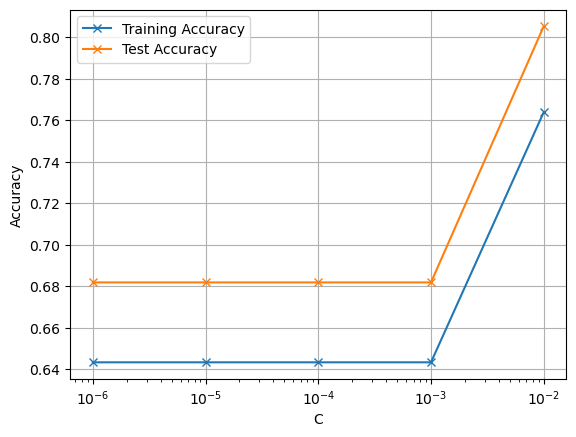

In [160]:
train_accuracies = []
test_accuracies = []
C = np.logspace(-2, -6, 5)
for i in C:
    r_logit_model = LogisticRegression(penalty='l2', C=i)
    r_logit_model.fit(X_train,Y_train)
    train_accuracies.append(testModel(Y_train, r_logit_model.predict(X_train)))
    test_accuracies.append(testModel(Y_test, r_logit_model.predict(X_test)))

plt.plot(C, train_accuracies, marker='x', label='Training Accuracy')
plt.plot(C, test_accuracies, marker='x', label='Test Accuracy')
plt.grid()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale('log')
plt.legend()
plt.show()

# Probability Thresholds

Recall that we are not estimating $Y$ directly, but instead the probability of $Y = 1 | X$. So far, our classification has been based on the which class has the higher probability. In other words, we have been using the classifier:
$$
  \hat{Y}(x) =
    \begin{cases}
      0 & \text{if } \hat{p}(x) < 0.5 \\
      1 & \text{if } \hat{p}(x) \geq 0.5 \\
    \end{cases}       
$$

However, we must also consider that the probability threshold of 0.5 might not be optimal. Indeed, consider our current data-set. Let's say we were going to use our model to decide who should go see a doctor and possibly get preventive treatment. In this case, incorrectly predicting that someone will not have Diabetes, when they will, is very costly - the person might face severe health consequences. On the other hand, incorrectly saying someone will have Diabetes, when they won't, is not as bad because the doctor would be able to catch this, and we would just waste a little time. 

This is one of the greatest strengths of logistic regression. The way we define and train them, mean we obtain good uncertainty estimates, so that we might make risk assessments!

## Exercise 3

1. Train a new logistic regression model, using the best regularization constant you found in exercise 2.

2. Build a new function which takes as inputs: your Logistic Regression model, a set of $X$ values in which to predict, and a probability threshold $T_p$. The function should return an array of predictions based on the new probability threshold. (Hint:  use the $\texttt{predict\_proba}$ method in $\texttt{LogisticRegression}$)

3. Investigate the effect of the probability threshold on the number of False Negatives and False Positives. Based on this analysis, what probability threshold would YOU choose? What kind of information would you want to make such a decision?

In [163]:
r_logit_model = LogisticRegression(penalty='l2', C=0.01)
r_logit_model.fit(X_train,Y_train)

LogisticRegression(C=0.01)

In [169]:
def Predict(model, values, prob_t):
    pred = r_logit_model.predict_proba(values)
    test_pred = r_logit_model.predict(values)
    return np.where(pred[:,1] > prob_t, 1, 0)


In [171]:
for i in np.linspace(0, 1, 11):
    print('\n\n---Threshold:', i)
    Y_pred = Predict(r_logit_model, X_test, i)
    testModel(Y_test, Y_pred, True)



---Threshold: 0.0
  Accuracy: 0.3181818181818182
[[  0 105]
 [  0  49]]


---Threshold: 0.1
  Accuracy: 0.33116883116883117
[[  3 102]
 [  1  48]]


---Threshold: 0.2
  Accuracy: 0.5064935064935064
[[30 75]
 [ 1 48]]


---Threshold: 0.30000000000000004
  Accuracy: 0.6688311688311688
[[63 42]
 [ 9 40]]


---Threshold: 0.4
  Accuracy: 0.7662337662337663
[[87 18]
 [18 31]]


---Threshold: 0.5
  Accuracy: 0.8051948051948052
[[98  7]
 [23 26]]


---Threshold: 0.6000000000000001
  Accuracy: 0.7597402597402597
[[103   2]
 [ 35  14]]


---Threshold: 0.7000000000000001
  Accuracy: 0.7142857142857143
[[104   1]
 [ 43   6]]


---Threshold: 0.8
  Accuracy: 0.6883116883116883
[[105   0]
 [ 48   1]]


---Threshold: 0.9
  Accuracy: 0.6818181818181818
[[105   0]
 [ 49   0]]


---Threshold: 1.0
  Accuracy: 0.6818181818181818
[[105   0]
 [ 49   0]]


I would choose a threshold of 0.2. There is an accuracy of about 0.51 but the number of false negatives is very low in comparison with the other classifications.